In [1]:
from ddm.data_handling import read_file
from ddm.processing import ddm_numpy #need to make sure we use the proper ddm function with dask functionality
from ddm.fitting import findMeanSqFFT_np, computeAB
from ddm.plotting import plotSingleExpFit, plotISF
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Begin by loading in data<br/>
Run the ddm function on the loaded dataset<br/>
From the resultant g(q, tau), determine A and B using findMeanSqFFT and computeAB - at this point move away from dask arrays.<br/>
Determine the ISF for various q values<br/>
Run fitting procedures on these with a few models and show the output<br/>

Compare to traditional particle tracking algorithms

**Loading in Data**<br/>
At this point a user input may be required if the programme detects a multi-experiment file

In [2]:
data_file = '../data/test_dataset_drift.tif'
output_file = "../data/test_dataset_drift_matrix.txt"
ddmData = read_file(data_file)

c:\Users\Maurits\miniconda3\envs\ddm_env\lib\site-packages\pims\bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '


**Running the DDM Function**<br/>
This part will determine the full DDM matrix as the square of the difference between Fourier transformed frames

In [4]:
# ddmData = ddmData.data[0:500,:,:]
# ddmData = np.asarray(ddmData)

In [5]:
ddmMatrix = ddm_numpy(ddmData)

[########################################] | 100% Completed | 12m 21s


In [ ]:
# Save data
np.savetxt(output_file, ddmMatrix)

In [3]:
# Load data
# ddmMatrix = np.loadtxt(output_file)

(0.0, 100.0)

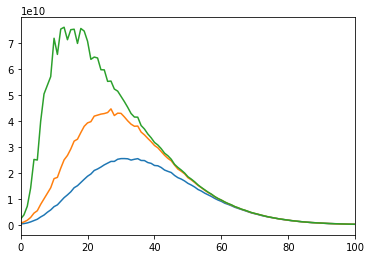

In [4]:
plt.plot(ddmMatrix[10,:])
plt.plot(ddmMatrix[25,:])
plt.plot(ddmMatrix[100,:])
plt.xlim(0, 100)

**Determining A and B**

In [5]:
meanSqFFT = findMeanSqFFT_np(ddmData)
A, B = computeAB(meanSqFFT)

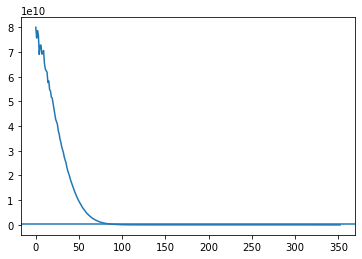

In [6]:
plt.plot(A[10:])
plt.axhline(B)
plt.show()

**Calculating the ISF**

In [7]:
isf = 1. - (ddmMatrix - B)/A

isf = np.transpose(isf)

To access a specific q value (in units of 1/pixels) one can use regular indexing of the 0th axis of the ISF

In [8]:
#zero q
isf[0]

#medium q
isf[len(isf)//2]

#last q
isf[len(isf)-1]

array([-6.13247757e-01, -6.98628023e-01,  2.29125467e-01,  4.03676467e-01,
        9.42796076e-02, -9.78129624e-02, -1.02844807e-01, -3.30160291e-01,
       -1.46512170e-01, -1.26220143e-01, -2.53783248e-02,  4.22417957e-01,
       -1.02655284e-01, -1.75174023e-01, -4.46301381e-01,  6.11242434e-01,
       -7.52899217e-01,  6.28102904e-01,  1.09612046e-01, -1.51193397e-01,
        1.63855132e-02,  5.29374591e-02,  3.12690183e-02, -1.58475831e-01,
        2.62573104e-02,  5.56408592e-01,  1.46165177e-01,  3.34994712e-02,
       -4.25847074e-01,  6.28262815e-01, -3.67197926e-03,  1.01787101e-01,
       -4.73521671e-01, -4.62545900e-01,  6.76838797e-03, -2.00041534e-02,
       -7.82912608e-01, -5.61557314e-02, -5.03077517e-02,  7.13449140e-02,
        1.14125631e+00, -4.12387363e-01, -9.06766113e-01, -4.33653067e-01,
       -1.95147414e-01, -1.97136225e-01, -3.36617114e-01, -2.46614847e-01,
        2.19530848e-01,  6.89448057e-01,  7.04350515e-01, -2.98463696e-01,
        2.96242790e-01,  

**Fitting/Plotting**<br/>
An example to fit and plot to a single exponential. Supported fitting functions are double exponential and the Schultz model

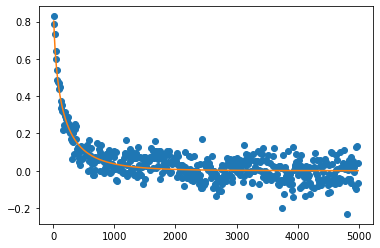

In [9]:
# taus = intTaus*ddmData.tScale #taus in milliseconds
taus = np.arange(1, len(ddmData) // 2) * 10 # in milliseconds
plotISF(isf, taus, q = len(isf)//2)
plotSingleExpFit(isf, taus)
plt.show()

### Store results

In [12]:
np.savetxt(output_file, ddmMatrix)